<a href="https://colab.research.google.com/github/nishreenk/UDACITY_DATA_SCIENCE_NANO/blob/main/NatureBasedSolution_LDA_model_03072021_NishrinKachwala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LDA MODEL with GenSim and Spacy. Nishrin Kachwala

Detecting Topics in Nature based solutions platforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Used this to scrape various Nature Based Solution Platform websites
#!python3 '/content/drive/My Drive/Colab Notebooks/OMDENA_WRI_CLIMATE/light_scraper.py'

In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!python -q -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=575b5a4f42b484777322e4a21315bc73e1342ba071011de8208723fb35af6a0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-6i7xrf8i/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!pip install langdetect  # to detect texts in various lanuages

     |████████████████████████████████| 983kB 12.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=45be7b949b98a2fb2eff1e8f6e900a0a887ef955ececf589dd8cd78be6dd7466
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# Download the relevant utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import gensim.corpora as corpora

from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS 
import en_core_web_lg
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from collections import Counter 
import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import requests
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#Data Extract Transform and Load

In [ ]:
#Download the file scraped from various NbS websites
lsc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls.csv')

In [ ]:
print('list shape is:', lsc.shape)
print('list cols are:', lsc.columns)

list shape is: (12801, 4)
list cols are: Index(['Unnamed: 0', 'Unnamed: 0.1', 'website_link', 'description'], dtype='object')


In [ ]:
lsc.head()

,Unnamed: 0,Unnamed: 0.1,website_link,description
0,0,0,http://bluenaturalcapital.org,The BNCFF helps to create opportunities for in...
1,1,1,http://canopy-energy.com/en/canopy-energy/,We cover all renewable energy business activit...
2,2,2,http://canopy-energy.com/en/construction-energ...,"For lighting public highways, gardens, parks, ..."
3,3,3,http://canopy-energy.com/en/developpement-ener...,Advisory of project owners and investors for t...
4,4,4,http://canopy-energy.com/en/distribution-energ...,Sale and installation of solar equipment direc...


In [ ]:
lsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12801 entries, 0 to 12800
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12801 non-null  int64 
 1   Unnamed: 0.1  12801 non-null  int64 
 2   website_link  12801 non-null  object
 3   description   12801 non-null  object
dtypes: int64(2), object(2)
memory usage: 400.2+ KB


In [ ]:
lsc.isna().sum()   # There are no missing elements in the dataframe

Unnamed: 0      0
Unnamed: 0.1    0
website_link    0
description     0
dtype: int64

In [ ]:
df = lsc[['website_link', 'description' ]]

In [ ]:
df.shape

(12801, 2)

In [ ]:
#Find the most commomly occuring words in the documents and add to stop list
def find_comm(data, num):
    ''' Find the most commomly occuring words in the documents and add to stop list
    Input: the document columns
    Output: stop word list
    '''
    stopwords = nltk.corpus.stopwords.words('english')

    #counter_comm_words = Counter(" ".join(df["description"]).split()).most_common(100) 
    counter_comm_words = Counter(" ".join(data).split()).most_common(num) 
    counter_comm_words 
    comm = pd.DataFrame(counter_comm_words, columns = ['Word','Count']) #Using Counter method

    ##creating new additions for stopwords from the most common words
    stop_list = comm['Word'][0:num].to_list() 
    # add other addtional stop words
    add_stop_words = ["crs", "help", "year", "s", "program", "need", "service", 
    "catholic", "mix", "parallel", "day", 'water', 'school', 'photo', 'child', 
    'support','water', 'community','work', 'find', 'a', 'like' , 'are','as', 
    'was', 'at', 'it', 'been', 'with', 'will', 'no', 'or', 'this', 'over',
    'about', 'there', 'high', 'possible', 'actually', 'time', 'follow', 'lead', 
    'effect', 'recent', 'use', 'likely', 'core', 'have', 'cause', 'come', 
    'present', 'actual', 'peerreviewe', 'relate', 'short', 'et', 'al', 'eu', 
    'come', 'use', 'als', 'th', 'need', 'follow', 'support', 'require', 
    'change', 'potential', 'important', 'include', 'project',
    'on','has','than','from', 'for', 'more', 'not', 'be', ]
    # extend the stop list
    stop_list.extend(add_stop_words)
    
    return stop_list

In [ ]:
stop_list = find_comm(df["description"], 100)

In [ ]:
stop_list[0:10]

['the', 'and', 'of', 'to', 'in', 'a', 'for', 'is', 'on', 'that']

In [ ]:
def clean(data):
    ''' 
        Using Regex to clean the columns. Make lower case, remove numbers and signs
        Clean up URL to root domain, remove duplicate, rows with less than 5 words
        Remove duplicates and less than 3 characters in a document
        Select only Engligh Lanuage texts
        Input: Data Col with the description and Website link
        Output: The clean and tokenized columns with URL's as Root Domain
    '''
    import regex as re

    def domain_extractor(u):
        ''' This function cleans up the URL and provide domain names
            Input: Column of websites
            Output: Column of Root Domains
        '''
        return re.search('\/\/([a-z.0-9A-Z-]*)\/',u+'/').group(1).replace('www.','')

    #Apply the function
    data['Root domain'] = data['website_link'].apply(lambda x: domain_extractor(x))

    # Clean and Tokenize
    
    data['clean'] = data.loc[:,'description'].str.lower()

    data['clean'] = data.loc[:,'clean'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

    # removing numbers and $ signs from the column
    data['clean'] = data.loc[:,'clean'].str.replace(r'[0-9]', '')  

    data['clean_token'] = data['clean'].apply(word_tokenize)
    data['clean_token'] = data['clean_token'].apply(lambda x: [word for word in x if word not in stop_list])
    data['clean_token_join'] = [' '.join(map(str, l)) for l in data['clean_token']]

    # Define a function that splits a string sentence and counts the words
    '''Input : a string as text
        Output: a count of words in the string
    '''
    def word_count(string):
        res = len(string.split())
        return res
    # Apply word_count to clean description    
    data.loc[:,'word count'] = data.loc[:, ('clean_token_join')].apply(lambda x: word_count(str(x)))

    # drop of rows in with less than 5 words in wordcount
    data = data[data['word count'] > 5]

    # Drop any duplicate rows
    data.drop_duplicates(subset=['clean_token_join'], inplace=True)

    # Remove words with 3 characters or less
    def remove_three(x):
        temp = x.split()
        result = []
        for word in temp:
            if len(word) > 3:
                result.append(word)
        return " ".join(result)

    data['clean_token_join'] = data['clean_token_join'].apply(lambda x: remove_three(x)) 

#    # Checking to see if all rows are in English
#    from langdetect import detect
#    def is_en(txt):
#        try:
#            return detect(txt)
#        except:
#            return False   
#    data['lanuage'] = data['clean_token_join'].apply(lambda x: is_en(x))
    return data

In [ ]:
clean(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,website_link,description,Root domain,clean,clean_token,clean_token_join,word count
0,http://bluenaturalcapital.org,The BNCFF helps to create opportunities for in...,bluenaturalcapital.org,the bncff helps to create opportunities for in...,"[bncff, helps, create, opportunities, investor...",bncff helps create opportunities investors par...,227
1,http://canopy-energy.com/en/canopy-energy/,We cover all renewable energy business activit...,canopy-energy.com,we cover all renewable energy business activit...,"[cover, renewable, energy, business, activitie...",cover renewable energy business activities sol...,17
2,http://canopy-energy.com/en/construction-energ...,"For lighting public highways, gardens, parks, ...",canopy-energy.com,for lighting public highways gardens parks and...,"[lighting, public, highways, gardens, parks, a...",lighting public highways gardens parks public ...,38
3,http://canopy-energy.com/en/developpement-ener...,Advisory of project owners and investors for t...,canopy-energy.com,advisory of project owners and investors for t...,"[advisory, owners, investors, purchase, sale, ...",advisory owners investors purchase sale financ...,62
4,http://canopy-energy.com/en/distribution-energ...,Sale and installation of solar equipment direc...,canopy-energy.com,sale and installation of solar equipment direc...,"[sale, installation, solar, equipment, directl...",sale installation solar equipment directly fin...,137
...,...,...,...,...,...,...,...
12796,https://www2.cifor.org/asia-pacific-rainforest...,"[['Green growth, sustainable land use and inve...",www2.cifor.org,'green growth sustainable land use and investm...,"['green, growth, investment, privatesector, pl...",'green growth investment privatesector pledges...,119
12797,https://www2.cifor.org/asia-pacific-rainforest...,"[['The registration has closed, thank you for ...",www2.cifor.org,'the registration has closed thank you for you...,"['the, registration, closed, thank, your, inte...",'the registration closed thank your interest v...,18
12798,https://www2.cifor.org/asia-pacific-rainforest...,"[['Minister of Environment and Forestry, Indon...",www2.cifor.org,'minister of environment and forestry indonesi...,"['minister, environment, forestry, indonesia, ...",'minister environment forestry indonesia 'mini...,854
12799,https://www2.cifor.org/asia-pacific-rainforest...,[['A Q&A with the manager of sustainability at...,www2.cifor.org,'a qa with the manager of sustainability at in...,"['a, qa, manager, sustainability, intrepid, tr...",manager sustainability intrepid travel worlds ...,301


In [ ]:
# Checking to see if all rows are in English
from langdetect import detect
def is_en(txt):
    try:
        return detect(txt)
    except:
        return False   

df['lanuage'] = df['clean_token_join'].apply(lambda x: is_en(x))

df = df[df.lanuage == 'en']    

In [ ]:
df.lanuage.nunique()

1

In [ ]:
#Save the cleaned file
df.to_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls_cleaned.csv')

In [ ]:
nlp= spacy.load("en")


In [ ]:
#  list of stop words.
# Updates spaCy's default stop words list with  additional words. 
nlp.Defaults.stop_words.update(stop_list)

#Updates spaCy's default stop words list with  additional words. 
#nlp.Defaults.stop_words.update(stopwords)
#nlp.Defaults.stop_words.update(add_stop_words)  # removing stopwords

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in nlp.Defaults.stop_words:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [ ]:
df_doc = temp['clean_token_join'].copy()

Lemmatize and Remove stopwords

In [ ]:
def pron_lemmatizer(doc):
    '''
    This takes in a doc of tokens from the NER and lemmatizes them. 
    Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    '''
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_sws(doc):
    '''This will remove stopwords and punctuation.
    Use token.text to return strings, which we'll need for Gensim.
    '''
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends these functions to the default pipeline.
nlp.add_pipe(remove_sws, name="sw", last=True)
nlp.add_pipe(pron_lemmatizer,name='lemm_pron',after='ner')


In [ ]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(df_doc):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Using gensim corpora create a dictionary, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

#words.filter_extremes(no_below=4, no_above=0.5, keep_n=100000)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [ ]:
len(corpus)

11773

#LDA MODEL
**Parameters in the model:**
*   *passes* controls how often we train the model on the entire corpus (set to 100)
chunksize controls how many documents are processed at a time in the training algorithm.
*   *chunksize* controls how many documents are processed at a time in the training algorithm.
*   *Dirichlet hyperparameter alpha* is the Document-Topic Density
*   *Dirichlet hyperparameter beta* is Word-Topic Density
*   *Perplexity* is a statistical measure of how well a probability model predicts a sample the statistic makes more sense when comparing it across different models with varying the number of topics. The model with the lowest perplexity is generally considered the “best”

* Model topic coherence Score: This score is a measure to judge how good a given topic model is.  *Topic Coherence* measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.








In [ ]:
# TUNING FOR OPTIMUM TOPIC NUMBER BASED ON PERPELXITY AND COHERENCE
def compute_coherence_values(corpus,  id2word, texts, limit, start=3, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    perplexity_values =[]
    model_list = []
    
    #   
    for num_topics in range(start, limit, step):  
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=num_topics, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           iterations=500,
                                           per_word_topics=True)
        
        model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        model_list.append(model_lda)

        coherence_values.append(model_lda.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))
    
    return  model_list, coherence_values, perplexity_values
    

In [ ]:
model_list, coherence_values, perplexity_values = compute_coherence_values(corpus=corpus, id2word=words, texts=doc_list, start=3, limit=25, step=3)

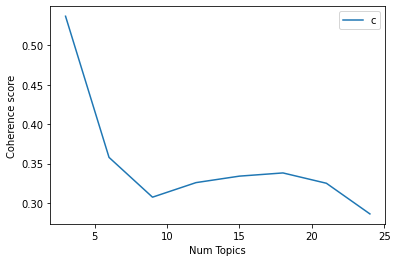

In [ ]:
limit=25; 
start=3; 
step=3; 
x = range(start, limit, step) 
#plt.plot(x, coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

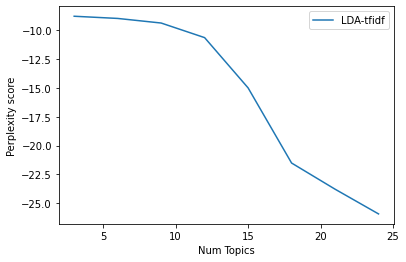

In [ ]:
limit=25;
start=3; 
step=3; 
x = range(start, limit, step) 
#plt.plot(x, perplexity_values, label="LDA") 
plt.plot(x, perplexity_values, label="LDA-tfidf")


plt.xlabel("Num Topics") 
plt.ylabel("Perplexity score") 
plt.legend() 
plt.show()

In [ ]:
# FINAL LDA model based on optimized Topic number
final_num_topics = 12
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=final_num_topics, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           iterations=500,
                                           per_word_topics=True)

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
perplexity_value = lda_model.log_perplexity(corpus)
print('\nCoherence Score: ', coherence_lda)
#print('\nPerpelxity:', perplexity_value)


Perplexity:  -10.561885233740204

Coherence Score:  0.32264531919101164


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.029*"system" + 0.029*"health" + 0.027*"technology" + 0.023*"challenge" + 0.022*"improve" + 0.022*"report" + 0.022*"increase" + 0.021*"crop" + 0.015*"bring" + 0.014*"agriculture"
Topic: 1 Word: 0.020*"world" + 0.014*"business" + 0.010*"social" + 0.009*"covid" + 0.009*"way" + 0.009*"live" + 0.008*"woman" + 0.008*"good" + 0.008*"home" + 0.007*"market"
Topic: 2 Word: 0.259*"family" + 0.076*"coffee" + 0.036*"rate" + 0.023*"flee" + 0.020*"fish" + 0.018*"authority" + 0.017*"goat" + 0.013*"joint" + 0.012*"night" + 0.011*"image"
Topic: 3 Word: 0.054*"organization" + 0.037*"address" + 0.034*"seed" + 0.032*"small" + 0.031*"plan" + 0.027*"case" + 0.026*"collaboration" + 0.025*"offer" + 0.024*"network" + 0.023*"bank"
Topic: 4 Word: 0.024*"economic" + 0.019*"provide" + 0.016*"future" + 0.013*"world" + 0.012*"create" + 0.012*"opportunity" + 0.011*"build" + 0.011*"energy" + 0.011*"policy" + 0.011*"impact"
Topic: 5 Word: 0.066*"share" + 0.035*"problem" + 0.033*"serve" + 0.032*"critical

LOOP OVER NUMBER OF TOPICS TO FIND BEST MODEL

#VISUALIZE RESULTS

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    ''' Function provides details on the dominant topics: 
        the main topic in each document: the Dominant topic, Perc Contribution 
        and Keywords for each document
        Input:ldamodel, the corpus and list of documents
        Output: Text, dominat topics in text, its percent contribution and the Topic keywords
    '''
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)


In [ ]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Create a Dominant topic dataframe columns
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()
df_dominant_topic['Dominant_Topic'].unique()

array([ 4.,  1.,  3.,  8.,  0.,  6., 11., 10.,  5.,  2.])

In [ ]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.8007,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio..."
1,1,1.0,0.3288,"world, business, social, covid, way, live, woman, good, home, market","[cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg..."
2,2,1.0,0.2335,"world, business, social, covid, way, live, woman, good, home, market","[light, public, highway, garden, park, public, private, space, private, system, industrial, site..."
3,3,3.0,0.2963,"organization, address, seed, small, plan, case, collaboration, offer, network, bank","[advisory, owner, investor, purchase, sale, financing, solar, biofuel, energy, client, completio..."
4,4,4.0,0.4960,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[sale, installation, solar, equipment, directly, final, customer, private, individual, company, ..."


In [ ]:
df_dominant_topic.groupby('Dominant_Topic').count()

,Document_No,Topic_Perc_Contrib,Keywords,Text
Dominant_Topic,,,,
0.0,797,797,797,797
1.0,5881,5881,5881,5881
2.0,1,1,1,1
3.0,76,76,76,76
4.0,3422,3422,3422,3422
5.0,94,94,94,94
6.0,1415,1415,1415,1415
8.0,11,11,11,11
10.0,75,75,75,75


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sent_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6659,"system, health, technology, challenge, improve, report, increase, crop, bring, agriculture","[shapefile, depict, major, determinant, characterize, dynamic, systems, ghana, brief, study, mar..."
1,1.0,0.7461,"world, business, social, covid, way, live, woman, good, home, market","[form, love, romantic, love, think, valentine, remember, god, agape, selfsacrifice, unconditiona..."
2,2.0,0.2365,"family, coffee, rate, flee, fish, authority, goat, joint, night, image","[related, activity, identification, location, artificial, reef, order, increase, fish, biomass, ..."
3,3.0,0.3706,"organization, address, seed, small, plan, case, collaboration, offer, network, bank","[bioversity, international, mainstreame, agrobiodiversity, system, scientific, agrobiodiversity,..."
4,4.0,0.8007,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio..."


In [ ]:
len(df_topic_sent_keywords)

11773

In [ ]:
len(sent_topics_sorteddf)

10

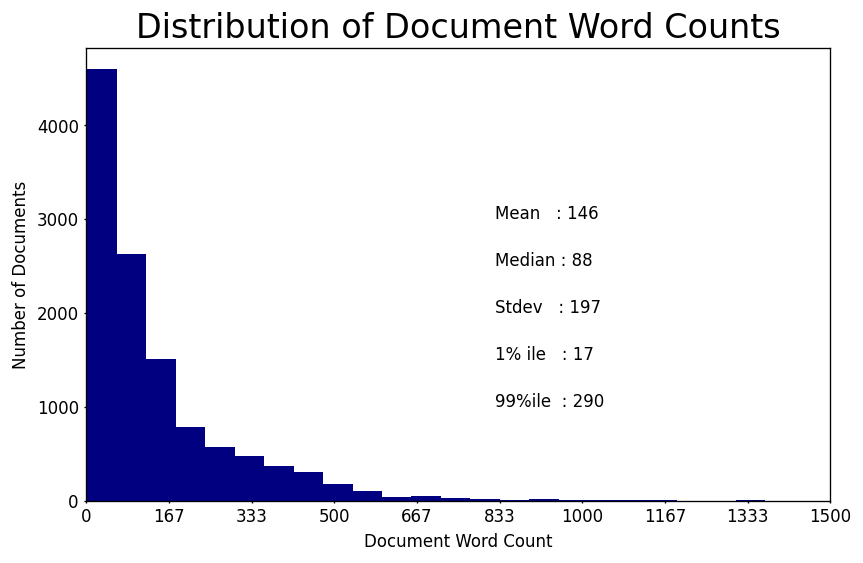

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,5), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(825, 3000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(825,  2500, "Median : " + str(round(np.median(doc_lens))))
plt.text(825,  2000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(825,  1500, "1% ile   : " + str(round(np.quantile(doc_lens, q=0.15))))
plt.text(825,  1000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.85))))

plt.gca().set(xlim=(0, 1500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=1)
plt.xticks(np.linspace(0,1500,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


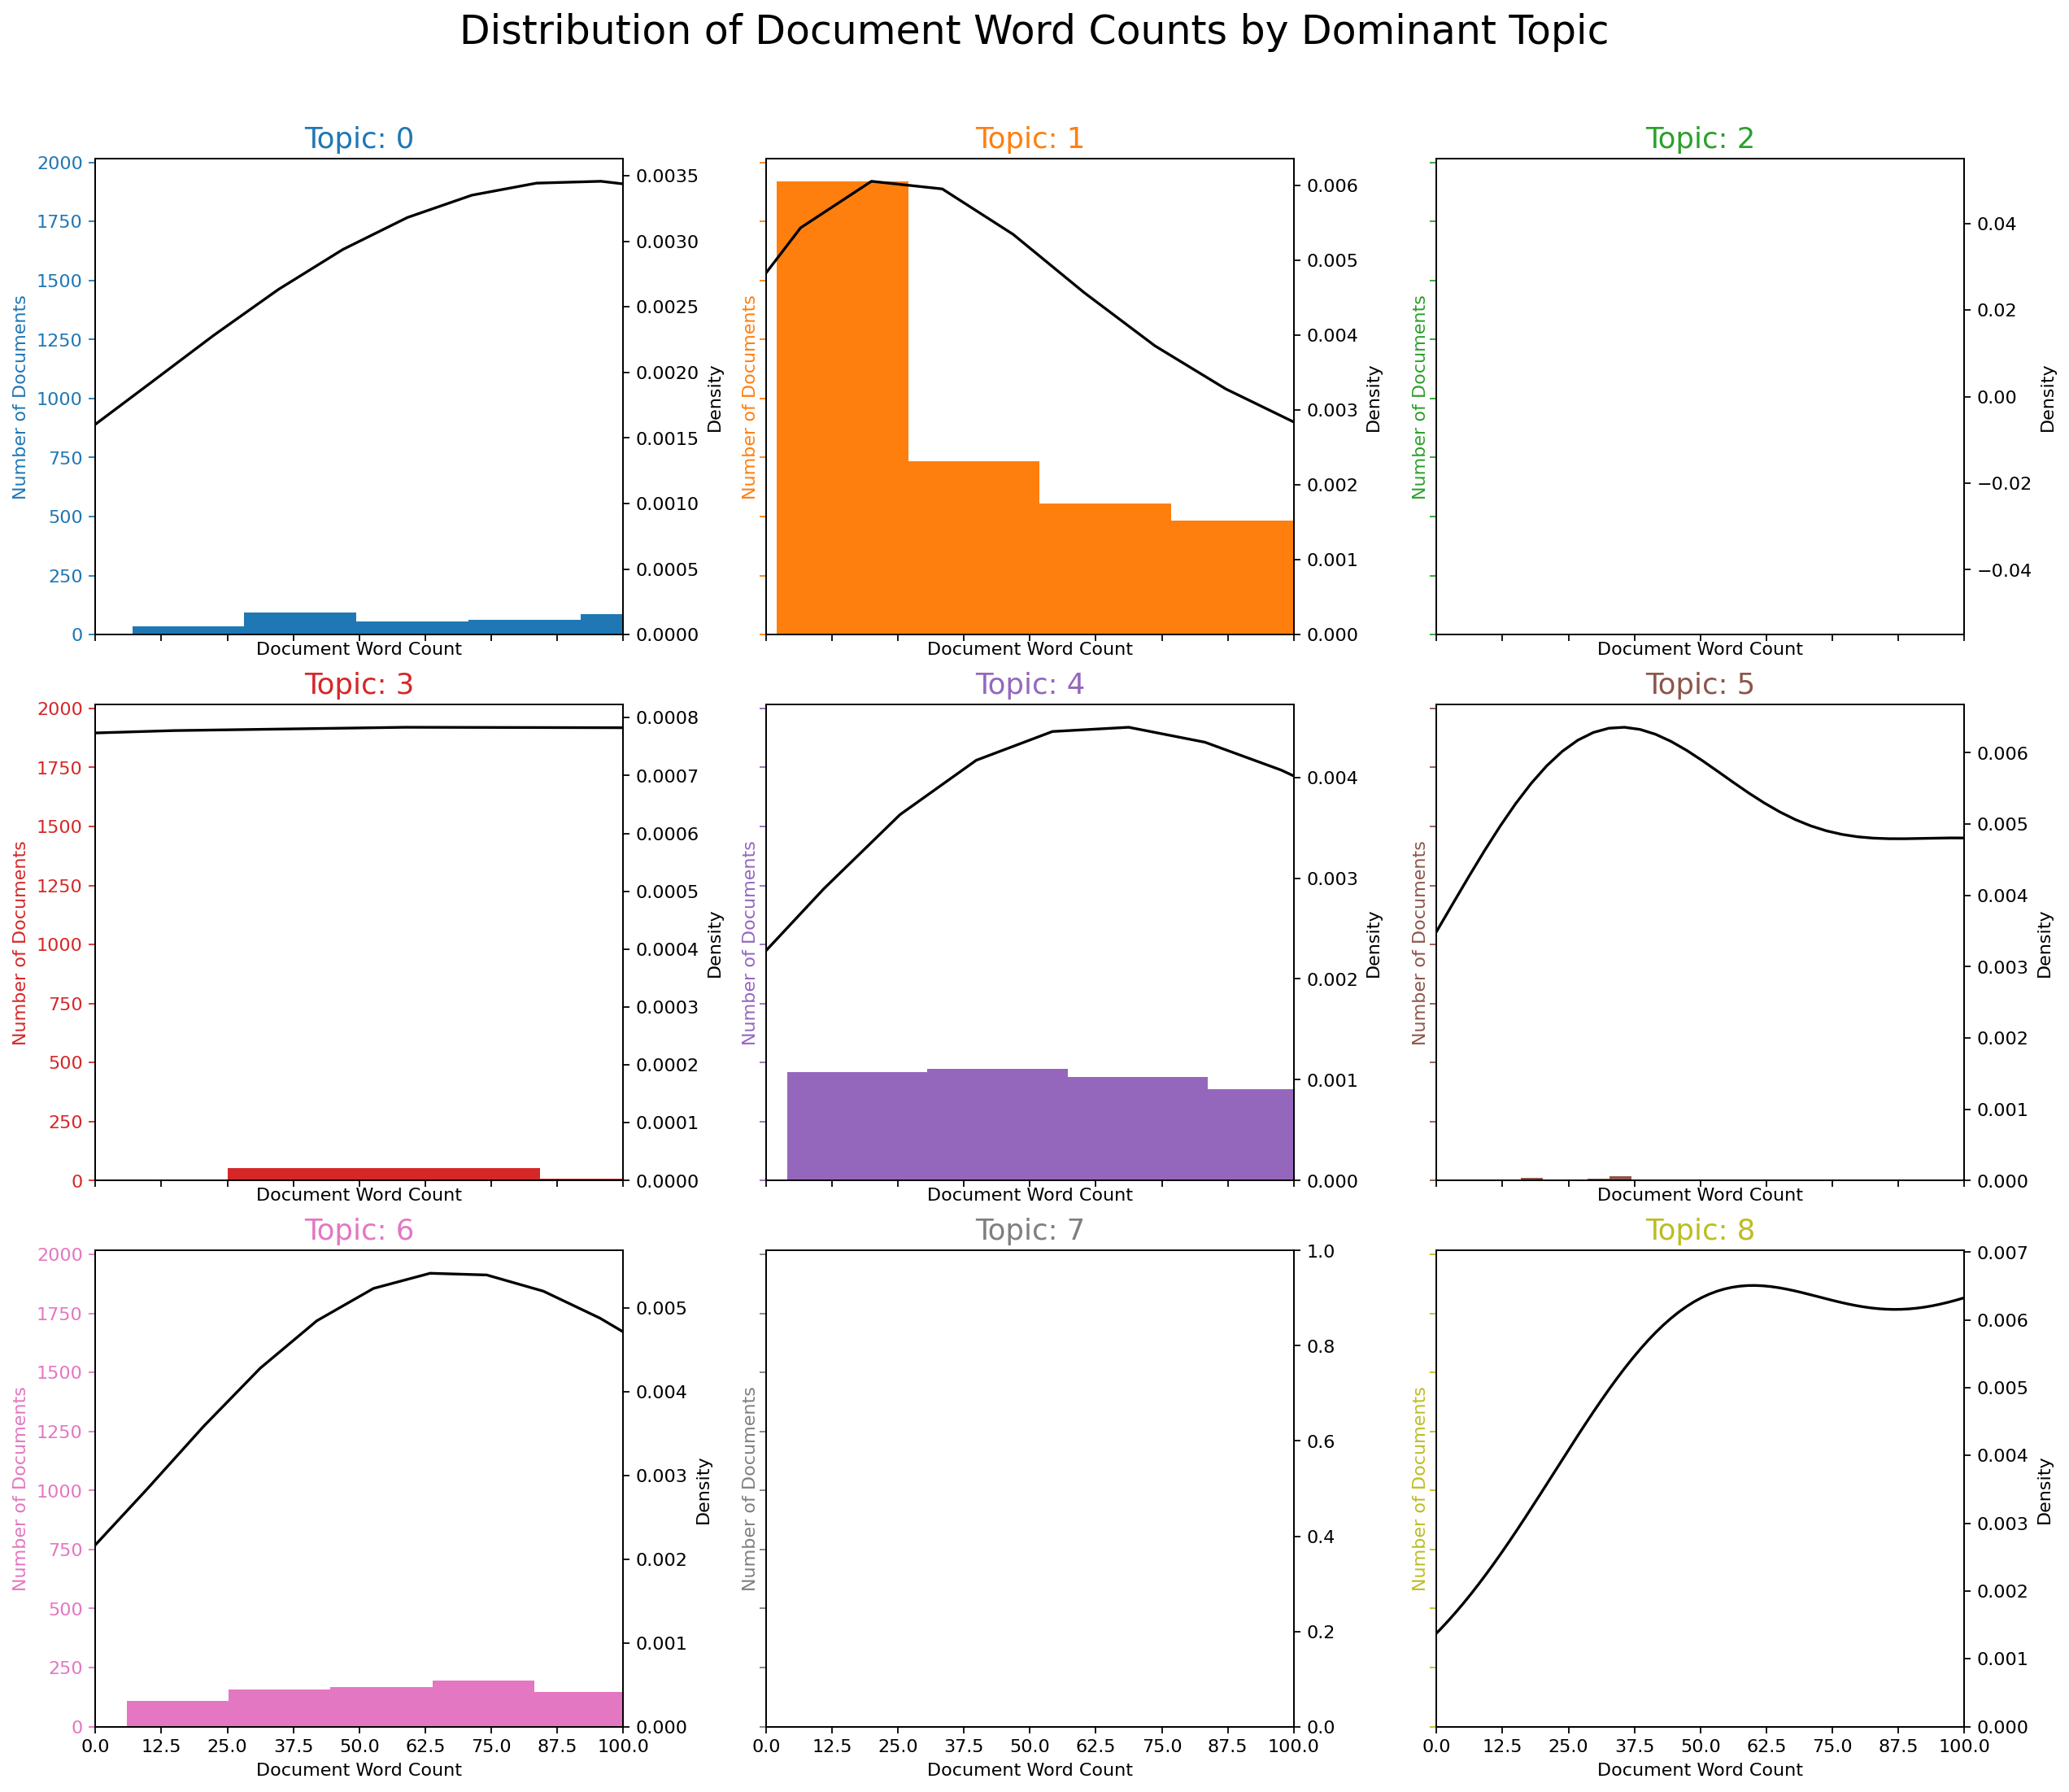

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

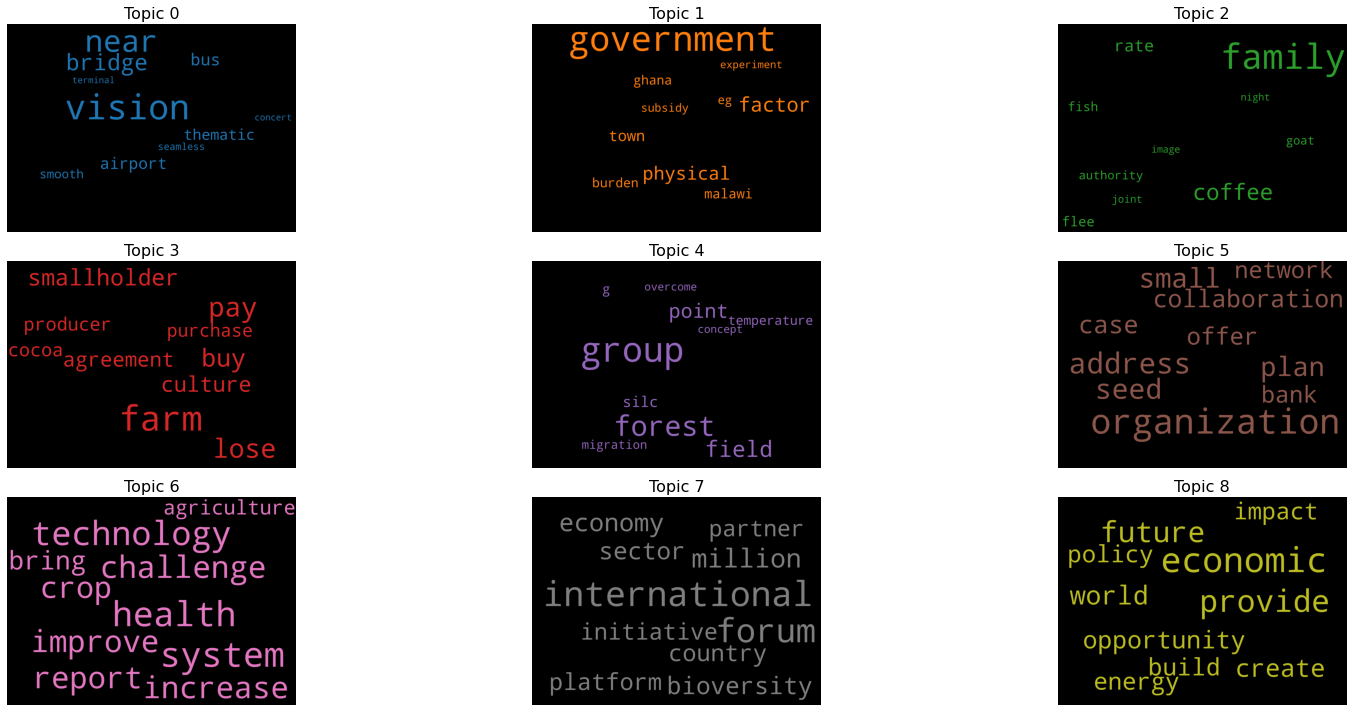

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=12,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(25,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

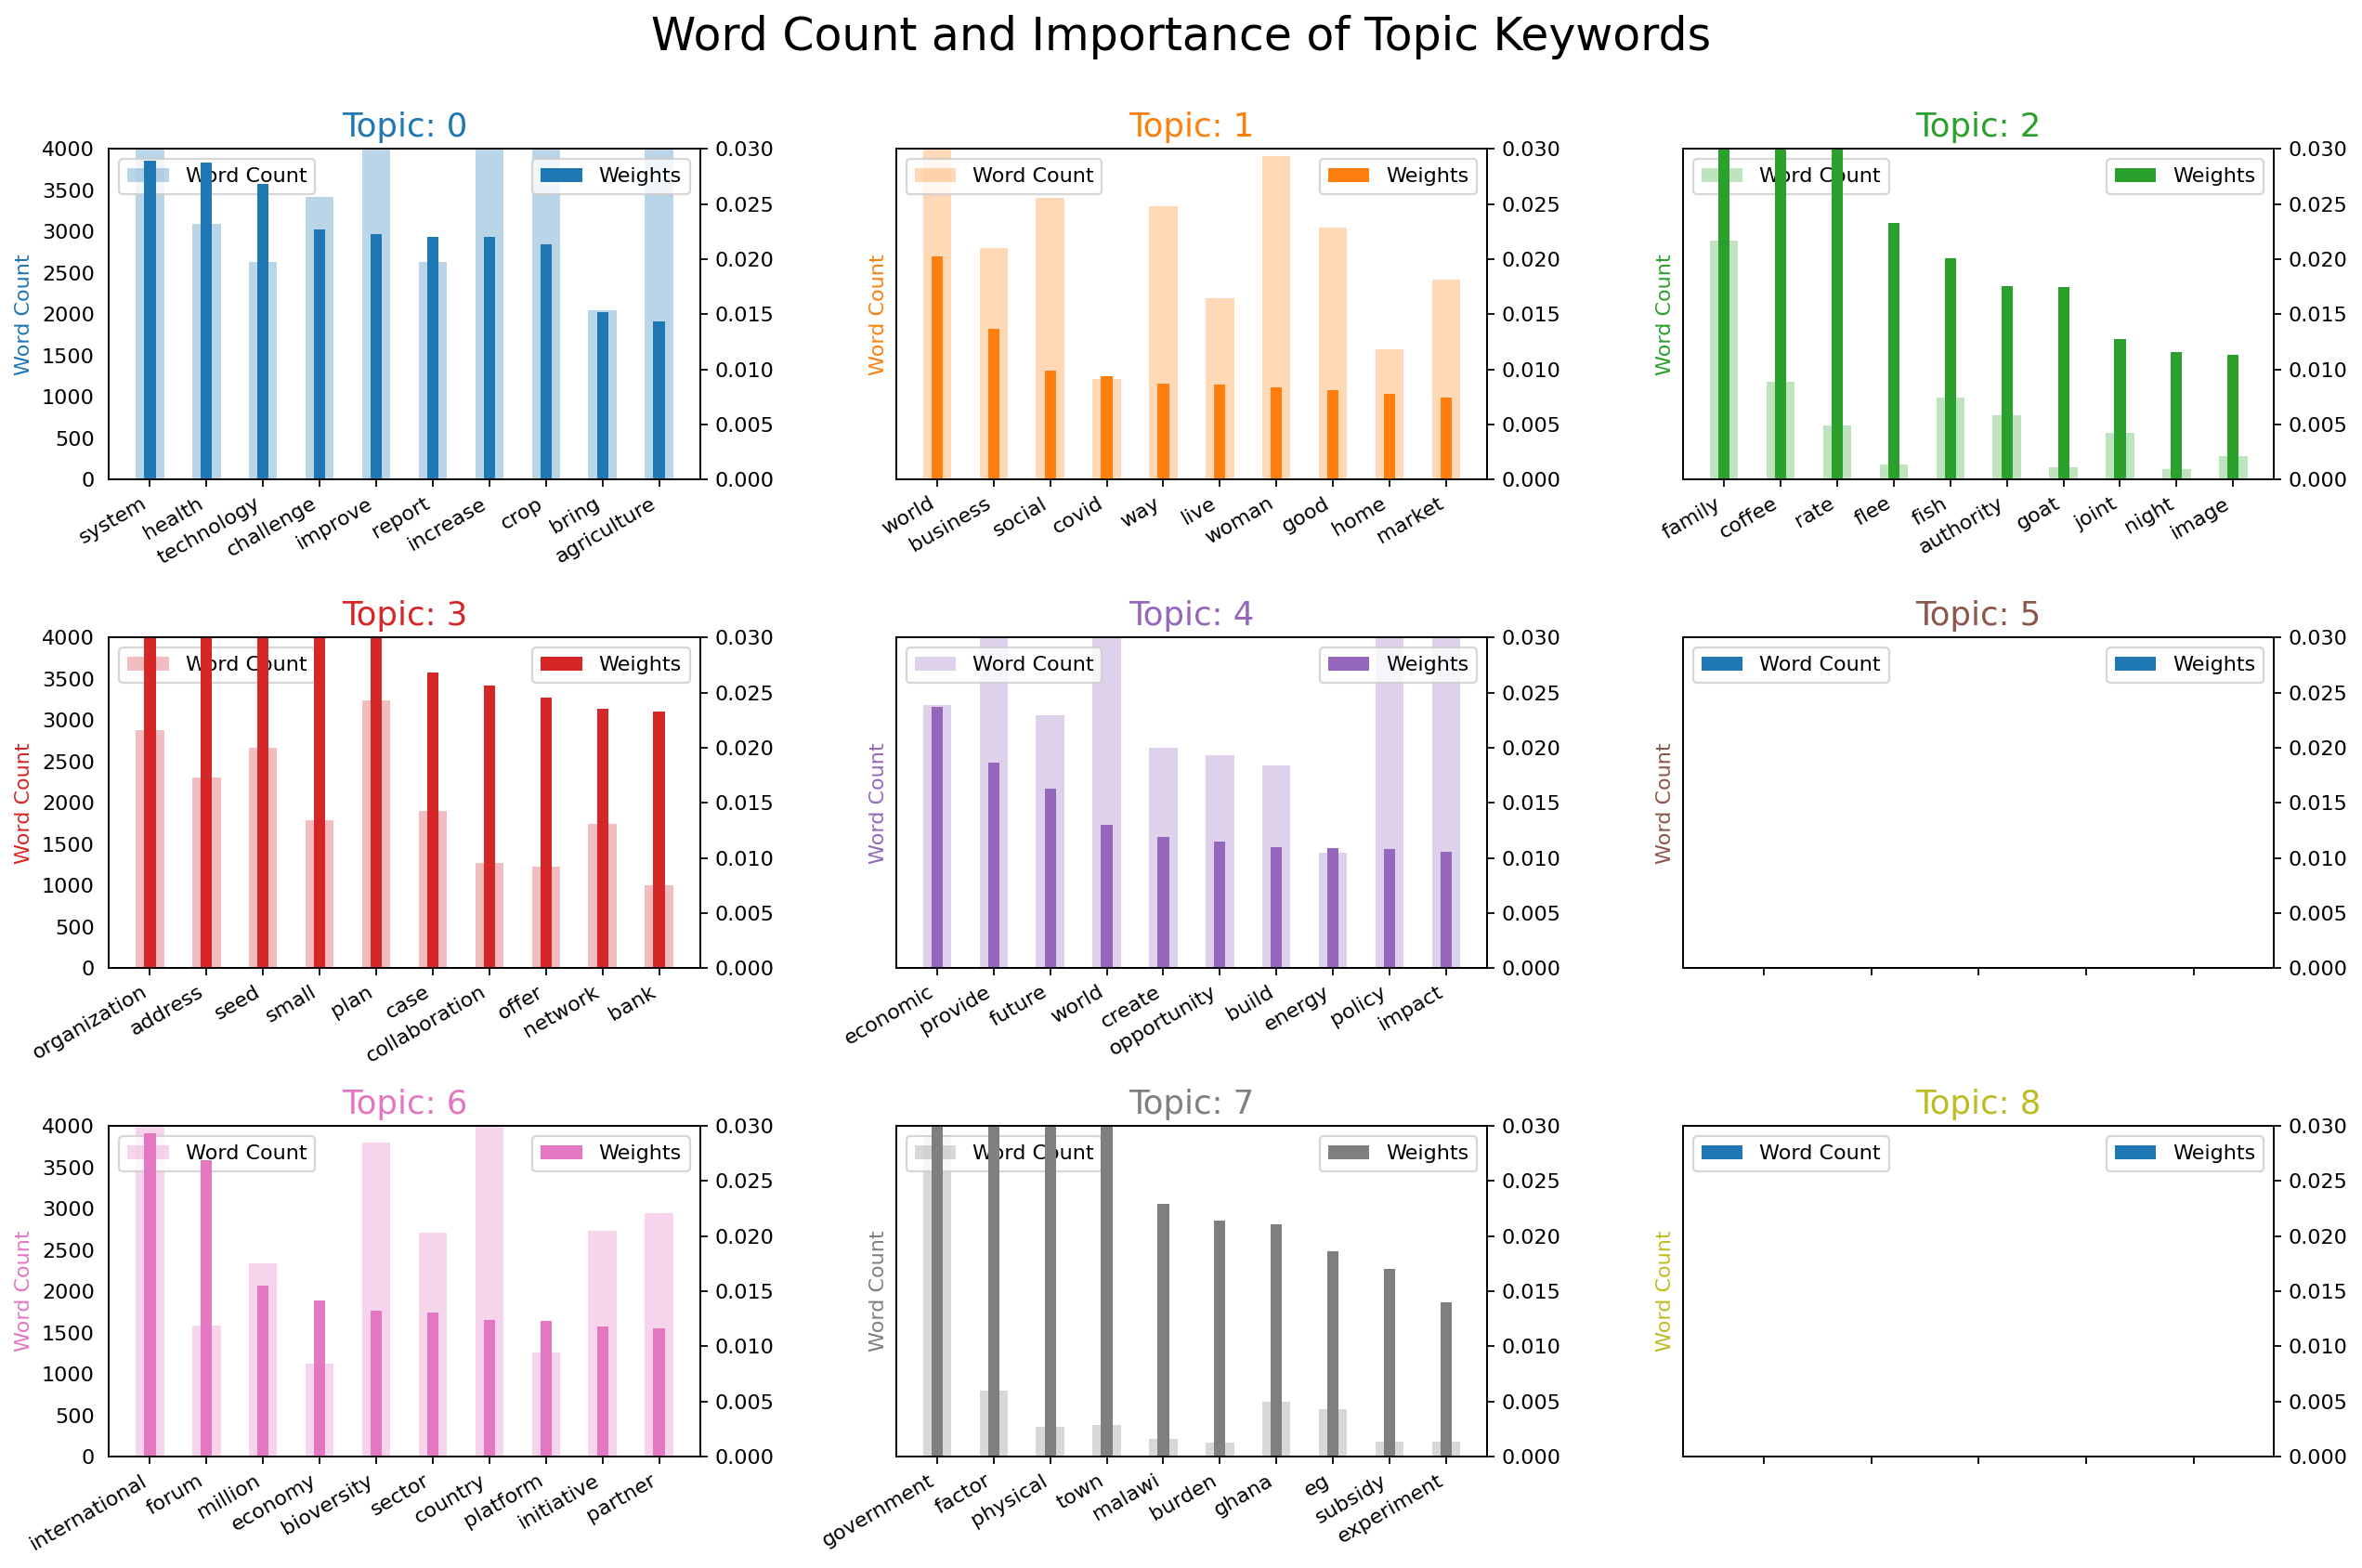

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_list for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 4000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The total number of documents attributed to each topic

In [ ]:
def topics_per_document(model, corpus, start=0, end=-1):
    '''The total number of documents attributed to each topic
        Input:Model and Corpus
        Output:Returns the dominant topics and topic percentage in each document
    '''
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 5 Keywords for each Topic
topic_top5words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top5words_stacked = pd.DataFrame(topic_top5words, columns=['topic_id', 'words'])
df_top5words = df_top5words_stacked.groupby('topic_id').agg(', \n'.join)
df_top5words.reset_index(level=0,inplace=True)

In [ ]:
df_top5words.head(11)

,topic_id,words
0,0,"system, \nhealth, \ntechnology"
1,1,"world, \nbusiness, \nsocial"
2,2,"family, \ncoffee, \nrate"
3,3,"organization, \naddress, \nseed"
4,4,"economic, \nprovide, \nfuture"
5,6,"international, \nforum, \nmillion"
6,7,"government, \nfactor, \nphysical"
7,9,"vision, \nnear, \nbridge"
8,10,"group, \nforest, \nfield"
9,11,"farm, \npay, \nlose"


In [ ]:
lda_model.show_topics(formatted=True)

[(9,
  '0.109*"vision" + 0.082*"near" + 0.041*"bridge" + 0.019*"bus" + 0.018*"airport" + 0.015*"thematic" + 0.010*"smooth" + 0.006*"seamless" + 0.005*"terminal" + 0.005*"concert"'),
 (7,
  '0.346*"government" + 0.056*"factor" + 0.045*"physical" + 0.030*"town" + 0.023*"malawi" + 0.021*"burden" + 0.021*"ghana" + 0.019*"eg" + 0.017*"subsidy" + 0.014*"experiment"'),
 (2,
  '0.259*"family" + 0.076*"coffee" + 0.036*"rate" + 0.023*"flee" + 0.020*"fish" + 0.018*"authority" + 0.017*"goat" + 0.013*"joint" + 0.012*"night" + 0.011*"image"'),
 (11,
  '0.094*"farm" + 0.053*"pay" + 0.050*"lose" + 0.044*"buy" + 0.037*"smallholder" + 0.033*"culture" + 0.030*"agreement" + 0.024*"cocoa" + 0.023*"producer" + 0.022*"purchase"'),
 (10,
  '0.177*"group" + 0.111*"forest" + 0.066*"field" + 0.051*"point" + 0.026*"silc" + 0.019*"g" + 0.019*"temperature" + 0.016*"migration" + 0.013*"overcome" + 0.013*"concept"'),
 (3,
  '0.054*"organization" + 0.037*"address" + 0.034*"seed" + 0.032*"small" + 0.031*"plan" + 0.027*

In [ ]:
df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()

10

# THIS PLOT ERRORS OUT WHEN SOME TOPICS ARE MISSING 
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.75, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#ax1.set_xticks(range(len(num_id)))
#num_id = df_top3words.topic_id
#if x in num_id:
#    try:
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top5words.loc[df_top5words.topic_id==x, 'words'].values[0])
   # except: 
    #    break
    
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10000)
ax1.tick_params(labelrotation=90)
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
#ax2.set_xticks(range(len(num_id)))
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.tick_params(labelrotation=90)
plt.show()

#VISUALIZE USIGN BOKEH AND PYLDAVIS
t-SNE (t-distributed stochastic neighbor embedding) algorithm to visualize the clusters of documents in 2D space with Bokeh

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.io import output_notebook
div = []

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points 
arr = arr[np.amax(arr, axis=1) > 0.4]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)


# tSNE Dimension Reduction with pca initialization
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
div


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1205 samples in 0.001s...
[t-SNE] Computed neighbors for 1205 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1205
[t-SNE] Computed conditional probabilities for sample 1205 / 1205
[t-SNE] Mean sigma: 0.034367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.857162
[t-SNE] KL divergence after 1000 iterations: 0.713492


[]

In [ ]:
xx =tsne_lda[:,0]
print(xx)

[32.572624  29.12288   -0.1138837 ... 10.515372  21.137438  24.624672 ]


In [ ]:
yy = tsne_lda[:,1]
print(yy)

[ -2.3201098  -3.7411172 -14.8424835 ... -25.119732   -1.5647149
 -24.146843 ]


In [ ]:
print(topic_num)

[3 3 1 ... 1 3 5]


In [ ]:
# Plot the Topic Clusters using Bokeh
import matplotlib.colors as mcolors
output_notebook()
n_topics = 12
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(topic_num), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
len(corpus)

11773

In [ ]:
!pip install pyldavis

     |████████████████████████████████| 1.7MB 12.4MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=acce4b971ffffa34c72f442dcdd2d0d45bfddeafffa978d219845e71b4b8b74e
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyldavis


In [ ]:
#lda_model[corpus[17]]

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.256674  0.172062       1        1  25.719258
4      0.254880 -0.028885       2        1  22.431815
6      0.237961  0.228014       3        1  17.250846
0      0.176365 -0.254306       4        1  14.356669
3     -0.013891 -0.195929       5        1   5.565232
8      0.023724 -0.088675       6        1   4.531220
5     -0.048843 -0.124288       7        1   3.867900
10    -0.143508  0.048590       8        1   2.446480
11    -0.160580  0.051312       9        1   1.673753
2     -0.154239  0.057650      10        1   1.287407
7     -0.206823  0.068330      11        1   0.709977
9     -0.221719  0.066126      12        1   0.159442, topic_info=                Term         Freq        Total Category  logprob  loglift
1358           group  7447.000000  7447.000000  Default  30.0000  30.0000
2392          family  5731.000000  5731.000000  Default  29.0000  29.0000
649       government  4216.000000  4216.000000  Default  28.0000  28.0000
759           forest  4662.000000  4662.000000  Default  27.0000  27.0000
418    international  8681.000000  8681.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
2467          edward     0.029816     0.876645  Topic12 -11.4273   3.0602
17127       aviation     0.030523     0.950355  Topic12 -11.4039   3.0029
62324            jgi     0.032116     1.251297  Topic12 -11.3530   2.7787
18940           fmnr     0.030080     0.920622  Topic12 -11.4185   3.0201
54949        goodall     0.030453     3.561920  Topic12 -11.4062   1.6794

[454 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0          1  0.692877  access
0          2  0.306942  access
3047      10  0.997518    acre
1895       1  0.014436  action
1895       2  0.197718  action
...      ...       ...     ...
16629     10  0.995863  window
4075       1  0.999779   woman
493        1  0.641599   world
493        2  0.358324   world
4077       1  0.999832   young

[466 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 1, 4, 9, 6, 11, 12, 3, 8, 10])

#TOPICS VISUALIZATION with 3D t-SNE

In [ ]:
tp = df_dominant_topic.copy()

In [ ]:

print(tp.shape)
tp.head()


(11773, 5)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.8007,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio..."
1,1,1.0,0.3288,"world, business, social, covid, way, live, woman, good, home, market","[cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg..."
2,2,1.0,0.2335,"world, business, social, covid, way, live, woman, good, home, market","[light, public, highway, garden, park, public, private, space, private, system, industrial, site..."
3,3,3.0,0.2963,"organization, address, seed, small, plan, case, collaboration, offer, network, bank","[advisory, owner, investor, purchase, sale, financing, solar, biofuel, energy, client, completio..."
4,4,4.0,0.4960,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[sale, installation, solar, equipment, directly, final, customer, private, individual, company, ..."


In [ ]:
tp = tp.dropna(axis=0)


In [ ]:
tp.shape

(11773, 5)

In [ ]:
tp['Dominant_Topic'] = tp['Dominant_Topic'].apply(lambda x: str(int(x)))

In [ ]:
tp.sample(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic
11176,11176,1,0.3035,"world, business, social, covid, way, live, woman, good, home, market","[fetch, distance, away, kilometer, mile, way, dirty, clean, able, monica, farmer, mother, remote...",Covid affecting Women in various ways
1593,1593,1,0.2710,"world, business, social, covid, way, live, woman, good, home, market","[press, conference, release, second, set, result, regional, comparative, explanatory, study, ter...",Covid affecting Women in various ways
1881,1881,1,0.4398,"world, business, social, covid, way, live, woman, good, home, market","[united, nations, york, septembera, international, initiative, enhance, protection, cultural, he...",Covid affecting Women in various ways
6583,6583,1,0.2375,"world, business, social, covid, way, live, woman, good, home, market","[cooperative, gujarat, solarpowered, pump, way, optimal, irrigation, generate, additional, incom...",Covid affecting Women in various ways
7532,7532,6,0.2959,"international, forum, million, economy, bioversity, sector, country, platform, initiative, partner","[agnes, casiplerola, member, committee, oversee, strategic, implementation, fiduciary, responsib...",International initatives on Bioversity


In [ ]:
topic_labels = {0: 'Technology to improve agriculture and crop yields', 1: 'Covid affecting Women in various ways', 2: 'Coffee Beans rate affecting farming families', 3: 'Bank provide seed money for small businesses', 4: 'Energy policy and future economic opportunites', 5: 'Topsoil loss problem', 6:'International initatives on Bioversity',7: 'Government subsidy experiments in Ghana and Malawi', 8: 'Trees in Partership',9:'Seamless Transportation for goods',10:'Conservancy efforts for Climate Change',11:'Cocoa producers agreement' }

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.029*"system" + 0.029*"health" + 0.027*"technology" + 0.023*"challenge" + 0.022*"improve" + 0.022*"report" + 0.022*"increase" + 0.021*"crop" + 0.015*"bring" + 0.014*"agriculture"
Topic: 1 Word: 0.020*"world" + 0.014*"business" + 0.010*"social" + 0.009*"covid" + 0.009*"way" + 0.009*"live" + 0.008*"woman" + 0.008*"good" + 0.008*"home" + 0.007*"market"
Topic: 2 Word: 0.259*"family" + 0.076*"coffee" + 0.036*"rate" + 0.023*"flee" + 0.020*"fish" + 0.018*"authority" + 0.017*"goat" + 0.013*"joint" + 0.012*"night" + 0.011*"image"
Topic: 3 Word: 0.054*"organization" + 0.037*"address" + 0.034*"seed" + 0.032*"small" + 0.031*"plan" + 0.027*"case" + 0.026*"collaboration" + 0.025*"offer" + 0.024*"network" + 0.023*"bank"
Topic: 4 Word: 0.024*"economic" + 0.019*"provide" + 0.016*"future" + 0.013*"world" + 0.012*"create" + 0.012*"opportunity" + 0.011*"build" + 0.011*"energy" + 0.011*"policy" + 0.011*"impact"
Topic: 5 Word: 0.066*"share" + 0.035*"problem" + 0.033*"serve" + 0.032*"critical

In [ ]:
tp.shape

(11773, 6)

In [ ]:
tp['Topic']= ""
for i in range(len(tp)):
    for j in range(final_num_topics):
        #print(i, k)
        if tp['Dominant_Topic'][i] == str(j):
            #print(i, k)
            tp['Topic'][i] = topic_labels[j]
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
tp.head(6)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic
0,0,4,0.8007,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio...",Energy policy and future economic opportunites
1,1,1,0.3288,"world, business, social, covid, way, live, woman, good, home, market","[cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg...",Covid affecting Women in various ways
2,2,1,0.2335,"world, business, social, covid, way, live, woman, good, home, market","[light, public, highway, garden, park, public, private, space, private, system, industrial, site...",Covid affecting Women in various ways
3,3,3,0.2963,"organization, address, seed, small, plan, case, collaboration, offer, network, bank","[advisory, owner, investor, purchase, sale, financing, solar, biofuel, energy, client, completio...",Bank provide seed money for small businesses
4,4,4,0.4960,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[sale, installation, solar, equipment, directly, final, customer, private, individual, company, ...",Energy policy and future economic opportunites
5,5,4,0.3479,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[found, canopy, energy, specialist, renewable, energy, energy, efficiency, large, build, operati...",Energy policy and future economic opportunites


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 1.9MB 22.1MB/s 
     |████████████████████████████████| 1.2MB 67.0MB/s 
     |████████████████████████████████| 890kB 48.6MB/s 
     |████████████████████████████████| 3.2MB 46.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp37-none-any.whl size=103068 sha256=0e1c6a9a56f959bea904419a5f577897a9335070164af3a856f51b441644bb6e
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0033e1429706df332a39c1d746e8a5859017acddb5c482072a9adda05a6cee7c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
tsne=pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDACITY/output1_ls_cleaned.csv', lineterminator='\n')

In [ ]:
tsne.head()

,Unnamed: 0,website_link,description,Root domain,clean,clean_token,clean_token_join,word count,lanuage
0,0,http://bluenaturalcapital.org,The BNCFF helps to create opportunities for investors to be part in building a sustainable futur...,bluenaturalcapital.org,the bncff helps to create opportunities for investors to be part in building a sustainable futur...,"['bncff', 'helps', 'create', 'opportunities', 'investors', 'part', 'building', 'future', 'bncff'...",bncff helps create opportunities investors part building future bncff focuses coastal ecosystems...,227,en
1,1,http://canopy-energy.com/en/canopy-energy/,We cover all renewable energy business activities and all solar market segments. We are speciali...,canopy-energy.com,we cover all renewable energy business activities and all solar market segments we are specialis...,"['cover', 'renewable', 'energy', 'business', 'activities', 'solar', 'market', 'segments', 'speci...",cover renewable energy business activities solar market segments specialist financing large proj...,17,en
2,2,http://canopy-energy.com/en/construction-energie-photovoltaique/,"For lighting public highways, gardens, parks, and any public or private space. Private systems :...",canopy-energy.com,for lighting public highways gardens parks and any public or private space private systems indu...,"['lighting', 'public', 'highways', 'gardens', 'parks', 'any', 'public', 'private', 'space', 'pri...",lighting public highways gardens parks any public private space private systems industrial sites...,38,en
3,3,http://canopy-energy.com/en/developpement-energie-photovoltaique/,"Advisory of project owners and investors for the purchase, sale and financing of their solar and...",canopy-energy.com,advisory of project owners and investors for the purchase sale and financing of their solar and ...,"['advisory', 'owners', 'investors', 'purchase', 'sale', 'financing', 'solar', 'biofuel', 'energy...",advisory owners investors purchase sale financing solar biofuel energy projects client throughou...,62,en
4,4,http://canopy-energy.com/en/distribution-energie-photovoltaique/,"Sale and installation of solar equipment directly to final customers (private individuals, compa...",canopy-energy.com,sale and installation of solar equipment directly to final customers private individuals compani...,"['sale', 'installation', 'solar', 'equipment', 'directly', 'final', 'customers', 'private', 'ind...",sale installation solar equipment directly final customers private individuals companies municip...,137,en


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-cls-token')
sentences = list(tsne['clean_token_join'])
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings)

/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
100%|██████████| 405M/405M [00:06<00:00, 62.5MB/s]


Sentence embeddings:
[[-0.33838227 -0.52094734 -0.26272914 ... -0.62469643 -0.8961607
  -0.39456657]
 [-0.054553   -0.22344041 -0.02147307 ... -0.07559187 -0.2871082
  -0.6672086 ]
 [ 0.45369568  1.163716   -0.16524749 ... -0.43014044 -0.55516285
  -0.04988025]
 ...
 [-0.5117173   0.75047666 -0.6052312  ...  0.5106699   0.19188902
  -0.6336797 ]
 [-1.054461    0.3791983  -0.32296783 ... -0.55980957  0.2666696
  -1.0933386 ]
 [-1.0726559   0.72774684  0.07347068 ... -0.39093077  0.04434722
  -0.98848355]]


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

features = sentence_embeddings



/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-

In [ ]:
perplexities = [5, 15, 25, 35, 45, 65, 100]
tsne2d = TSNE(n_components=2, random_state=0, perplexity=65)

In [ ]:

tsne3d = TSNE(n_components=3, random_state=0, perplexity=65)

In [ ]:
del projections

In [ ]:
projections = tsne3d.fit_transform(features)

In [ ]:
import plotly.express as px

In [ ]:
#Experiments wit different perplexity values
for perplexity in perplexities:

    tsne3d = TSNE(n_components=3, random_state=0, perplexity=perplexity)
    projections = tsne3d.fit_transform(features)
    fig = px.scatter(
    projections, x=0, y=1, color=tp.Dominant_Topic,  template="simple_white",
    labels = {
            '0': '', '1':'',  'color':'Topic',
        },
    title= "Perplexity=%d" % perplexity,

    width=1000, height=600
    )
    fig.update_traces(textposition='top center')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.update_traces(marker_size=10, showlegend=True)
    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    fig.show()

In [ ]:
tp.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic
0,0,4,0.8007,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[bncff, create, opportunity, investor, build, future, bncff, focus, coastal, ecosystem, key, bio...",Energy policy and future economic opportunites
1,1,1,0.3288,"world, business, social, covid, way, live, woman, good, home, market","[cover, renewable, energy, business, activity, solar, market, segment, specialist, finance, larg...",Covid affecting Women in various ways
2,2,1,0.2335,"world, business, social, covid, way, live, woman, good, home, market","[light, public, highway, garden, park, public, private, space, private, system, industrial, site...",Covid affecting Women in various ways
3,3,3,0.2963,"organization, address, seed, small, plan, case, collaboration, offer, network, bank","[advisory, owner, investor, purchase, sale, financing, solar, biofuel, energy, client, completio...",Bank provide seed money for small businesses
4,4,4,0.4960,"economic, provide, future, world, create, opportunity, build, energy, policy, impact","[sale, installation, solar, equipment, directly, final, customer, private, individual, company, ...",Energy policy and future economic opportunites


In [ ]:
fig = px.scatter(
    #projections, x=0, y=1, color=tsne.Dominant_Topic,  template="simple_white",
    projections, x=0, y=1, color=tp.Topic,  labels={'color': 'Topic'}, template="simple_white",
    #hover_data=tp['claim_label'],
    #projections, x=0, y=1, color=tp.Topic, template="simple_white",
    #labels = {
     #       '0': '', '1':'',  'color':'Topic',
    #    },
    #hover_data = {'x': False, 'Claim label': [tp.claim_label], 'Aim' : [tp.Keywords]},
    #hover_data = [tp.Topic, tp.Keywords],

    #hover_data = {'Root domain': df['Root domain'], 'Aim' : df['Topic']},

    width=1600, height=900
    )
fig.update_traces(textposition='top center')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_traces(marker_size=10, showlegend=True)
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [ ]:
perplexity =65
fig1 = px.scatter_3d(
        projections, x=0, y=1, z = 2, color=tp.Topic, template="plotly",
        #hover_data = {'Claim Label': [tp.claim_label], 'Topic' : [tp.Topic], 'Keywords': [tp.Keywords]},
        #hover_data = { 'Keywords': [tp.Keywords]},
        #hover_data =[tp.Dominant_Topic,  tp.Keywords],
        labels = {'0': 'x', '1':'y', '2':'z'},
        title= "Perplexity=%d" % perplexity,
        width=1600, height=700
    )
fig1.update_traces(marker_size=5)
fig1.update_traces(mode='markers', marker_size=5, marker_line_width=2)
fig1.update_layout(
    scene=dict(
        xaxis_title="",
        yaxis_title="",
        zaxis_title="",
        xaxis=dict(showticklabels=False, ticks=""),
        yaxis=dict(showticklabels=False, ticks=""),
        zaxis=dict(showticklabels=False, ticks=""),
        aspectratio_x=1.75, aspectratio_y=1.75, aspectratio_z=1.1
    ),
    margin=dict(l=0, r=0, b=1, t=0),
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
    )

)
fig1.show()

In [ ]:
fig1.write_html("/content/drive/My Drive/Colab Notebooks/UDACITY/final_out1_65px_03072021.html")